In [7]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler

# --- 1. 定義計算指標的函數 ---

def calculate_sse(X, labels, centers=None):
    """計算 SSE (Sum of Squared Errors)"""
    if centers is not None:
        sse = 0
        for i, center in enumerate(centers):
            cluster_points = X[labels == i]
            sse += np.sum((cluster_points - center) ** 2)
        return sse
    else:
        sse = 0
        unique_labels = np.unique(labels)
        for label in unique_labels:
            if label == -1: continue # 忽略雜訊
            cluster_points = X[labels == label]
            center = np.mean(cluster_points, axis=0)
            sse += np.sum((cluster_points - center) ** 2)
        return sse

def calculate_entropy(labels):
    """計算分群的 Entropy"""
    # 計算每個群的機率分佈
    value_counts = pd.Series(labels).value_counts(normalize=True)
    return entropy(value_counts)

def get_cluster_accuracy(y_true, y_pred):
    """
    計算分群 Accuracy。
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 處理雜訊點 (DBSCAN 的 -1)
    mask = y_pred != -1
    if not any(mask): return 0.0 # 全是雜訊

    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    D = max(y_pred_clean.max(), y_true_clean.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred_clean.size):
        w[y_pred_clean[i], y_true_clean[i]] += 1

    # 尋找最大匹配
    row_ind, col_ind = linear_sum_assignment(w.max() - w)

    # 計算轉換後的準確度
    new_y_pred = np.zeros_like(y_pred_clean)
    for i, j in zip(row_ind, col_ind):
        new_y_pred[y_pred_clean == i] = j

    return accuracy_score(y_true_clean, new_y_pred)

def plot_clusters(X, labels, title, markers_map):
    """
    畫圖函數
    """
    plt.figure(figsize=(6, 5))
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        if label == -1: # DBSCAN 雜訊
            marker = 'x'
            color = 'black'
            label_name = 'Noise'
        else:
            # 根據群的順序分配標記，若超過定義則循環使用
            marker_key = i % len(markers_map)
            marker = markers_map.get(i, list(markers_map.values())[i % len(markers_map)])
            color = colors[i]
            label_name = f'Cluster {label}'

        plt.scatter(X[labels == label, 0], X[labels == label, 1],
                    c=[color], marker=marker, label=label_name, s=50, alpha=0.8)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# 通用執行函數
def run_clustering(algorithm, name, X, y_true, markers):
    start_time = time.time()

    # 訓練與預測
    if "KMeans" in name:
        labels = algorithm.fit_predict(X)
        centers = algorithm.cluster_centers_
    else:
        # DBSCAN 和 Hierarchical
        labels = algorithm.fit_predict(X)
        centers = None

    end_time = time.time()

    # 計算指標
    duration = end_time - start_time
    sse = calculate_sse(X, labels, centers)
    acc = get_cluster_accuracy(y_true, labels)
    ent = calculate_entropy(labels)

    print(f"--- {name} 結果 ---")
    print(f"花費時間: {duration:.4f} 秒")
    print(f"SSE: {sse:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Entropy: {ent:.4f}")
    print("-" * 30)

    # 畫圖
    plot_clusters(X, labels, f"{name} Result", markers)


==================== 題目 1: Banana Dataset ====================
--- K-Means (Banana) 結果 ---
花費時間: 0.0444 秒
SSE: 4408.5019
Accuracy: 0.8219
Entropy: 0.6870
------------------------------


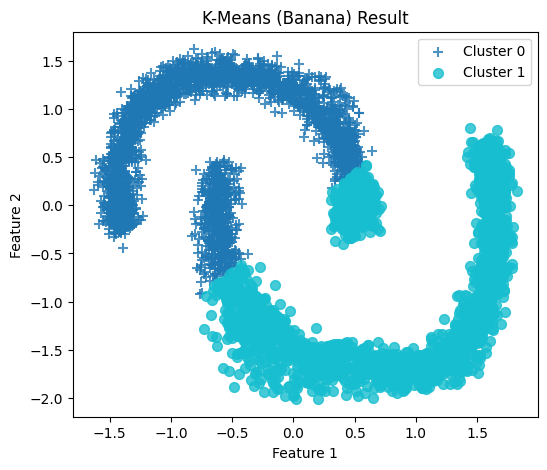

--- Hierarchical (Banana) 結果 ---
花費時間: 0.4641 秒
SSE: 4799.7781
Accuracy: 0.7302
Entropy: 0.6897
------------------------------


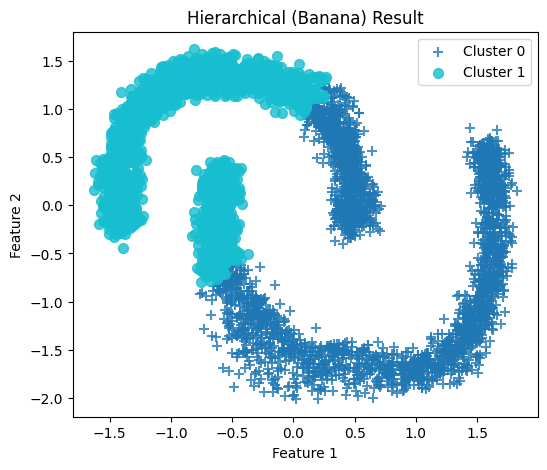

--- DBSCAN (Banana) 結果 ---
花費時間: 0.0847 秒
SSE: 9622.0000
Accuracy: 0.5238
Entropy: 0.0000
------------------------------


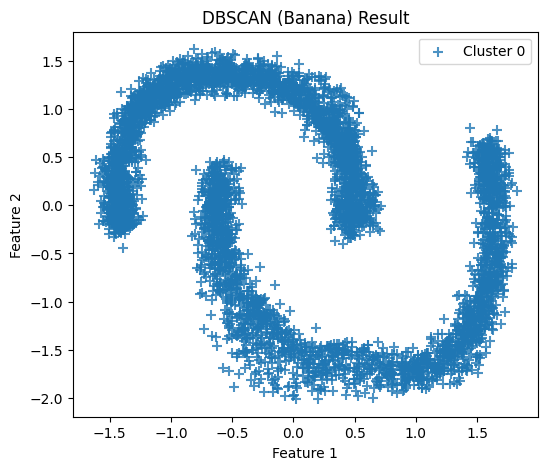


==================== 題目 2: Sizes3 Dataset ====================
--- K-Means (Sizes3) 結果 ---
花費時間: 0.1005 秒
SSE: 395.6470
Accuracy: 0.9800
Entropy: 1.0332
------------------------------


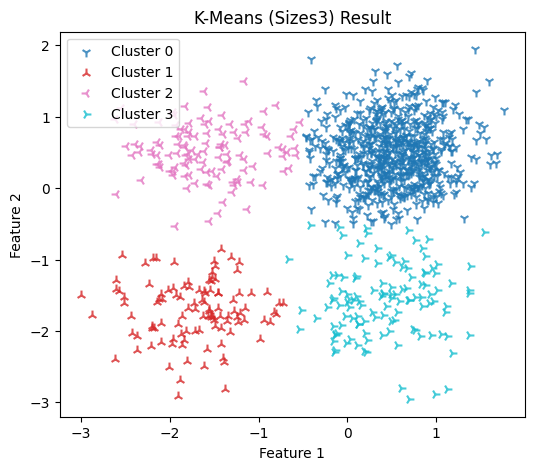

--- Hierarchical (Sizes3) 結果 ---
花費時間: 0.0130 秒
SSE: 431.8814
Accuracy: 0.9700
Entropy: 0.9765
------------------------------


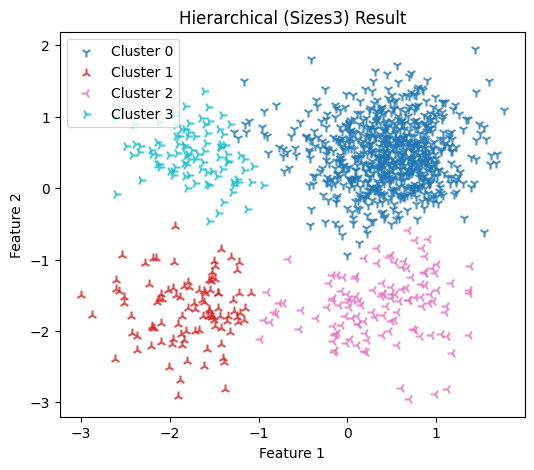


>>> 題目 3: DBSCAN 參數比較 (Sizes3)

[DBSCAN 參數測試] eps=0.3, min_samples=5
--- DBSCAN (eps=0.3) 結果 ---
花費時間: 0.0019 秒
SSE: 1840.6088
Accuracy: 0.6776
Entropy: 0.1206
------------------------------


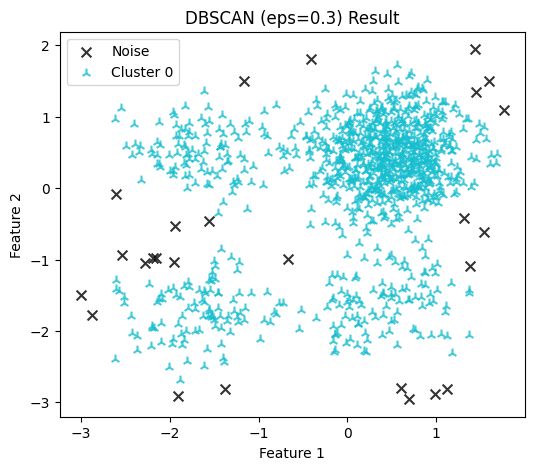


[DBSCAN 參數測試] eps=0.5, min_samples=5
--- DBSCAN (eps=0.5) 結果 ---
花費時間: 0.0178 秒
SSE: 1956.7639
Accuracy: 0.6700
Entropy: 0.0367
------------------------------


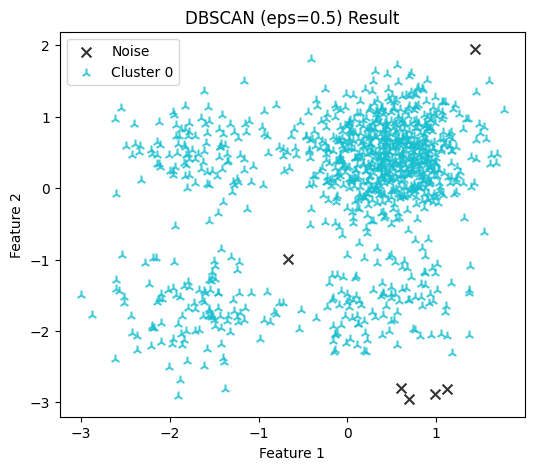


[DBSCAN 參數測試] eps=0.5, min_samples=10
--- DBSCAN (eps=0.5) 結果 ---
花費時間: 0.0255 秒
SSE: 1956.7639
Accuracy: 0.6700
Entropy: 0.0367
------------------------------


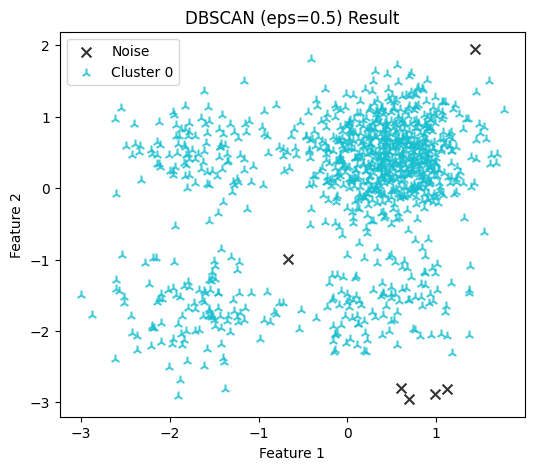


[DBSCAN 參數測試] eps=0.8, min_samples=5
--- DBSCAN (eps=0.8) 結果 ---
花費時間: 0.0206 秒
SSE: 2000.0000
Accuracy: 0.6670
Entropy: 0.0000
------------------------------


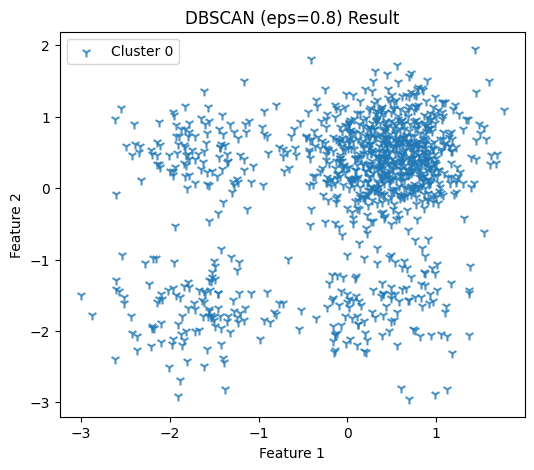

In [6]:
path_banana = "banana(1).csv"
path_sizes3 = "sizes3(1).csv"

# 載入資料函數
def load_data(path, label_col):
    df = pd.read_csv(path)
    # 特徵選擇
    X = df.drop(columns=[label_col]).values
    y = df[label_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

# ==========================================
# 題目 1: Banana 資料集 (分 2 群)
# ==========================================
print("\n" + "="*20 + " 題目 1: Banana Dataset " + "="*20)

try:

    X_ban, y_ban = load_data(path_banana, 'class')

    # 設定畫圖標記：同一群使用相同標記 "+" 及 "O"
    markers_banana = {0: '+', 1: 'o'}

    # 1. K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    run_clustering(kmeans, "K-Means (Banana)", X_ban, y_ban, markers_banana)

    # 2. 階層式分群 (Hierarchical)
    hc = AgglomerativeClustering(n_clusters=2)
    run_clustering(hc, "Hierarchical (Banana)", X_ban, y_ban, markers_banana)

    # 3. DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    run_clustering(dbscan, "DBSCAN (Banana)", X_ban, y_ban, markers_banana)

except Exception as e:
    print(f"Banana 資料集執行錯誤 (請檢查檔案路徑或欄位名稱): {e}")


# ==========================================
# 題目 2 & 3: Sizes3 資料集 (分 4 群)
# ==========================================
print("\n" + "="*20 + " 題目 2: Sizes3 Dataset " + "="*20)

try:
    X_sizes, y_sizes = load_data(path_sizes3, 'class')

    # 設定畫圖標記：1, 2, 3, 4

    markers_sizes = {0: '1', 1: '2', 2: '3', 3: '4'}

    # 1. K-Means
    kmeans_s = KMeans(n_clusters=4, random_state=42, n_init=10)
    run_clustering(kmeans_s, "K-Means (Sizes3)", X_sizes, y_sizes, markers_sizes)

    # 2. 階層式分群
    hc_s = AgglomerativeClustering(n_clusters=4)
    run_clustering(hc_s, "Hierarchical (Sizes3)", X_sizes, y_sizes, markers_sizes)

    # 3. DBSCAN
    print("\n>>> 題目 3: DBSCAN 參數比較 (Sizes3)")

    # 設定幾組不同的參數來測試
    params = [
        (0.3, 5),
        (0.5, 5),
        (0.5, 10),
        (0.8, 5)
    ]

    for eps, min_samples in params:
        print(f"\n[DBSCAN 參數測試] eps={eps}, min_samples={min_samples}")
        db = DBSCAN(eps=eps, min_samples=min_samples)
        run_clustering(db, f"DBSCAN (eps={eps})", X_sizes, y_sizes, markers_sizes)

except Exception as e:
    print(f"Sizes3 資料集執行錯誤: {e}")